# Kaggle: Predict Loan Payback — Feature Engineering

**Notebook:** `03_feature_engineering.ipynb`
**Author:** Brice Nelson
**Organization:** Kaggle Series | Brice Machine Learning Projects
**Date Created:** November 15, 2025
**Last Updated:** November 16, 2025

---

## 🧭 Purpose

This notebook focuses on **feature engineering** for the *Predict Loan Payback* Kaggle competition.
Feature engineering is where we convert domain knowledge and statistical insight into **predictive power**, increasing the model’s ability to distinguish between loans that are repaid vs. defaulted.

Whereas `02_data_cleaning.ipynb` prepared a clean, numeric, and aligned dataset, this notebook builds **new, informative features** that enhance model signal.

### **Objectives**
1. Import scaled training and test datasets from `/data/processed/`.
2. Engineer domain-driven features (credit, income, debt, and loan characteristics).
3. Validate distributions and inspect transformations.
4. Export a feature-enhanced dataset for modeling.

---

## 🧱 Feature Engineering Roadmap

The engineered features planned for this notebook:

### **1. Financial Ratio Features**
- **Loan-to-Income Ratio:** `loan_amount / annual_income`
- **Debt-to-Income Bucket:** Flag or bin DTI levels
- **Interest Rate Stress Feature:** Higher-than-expected interest rates relative to credit score

### **2. Credit Behavior Features**
- **Credit Score Buckets:** Very low → very high
- **Grade/Subgrade Interactions:** E.g., `grade * subgrade`
- **Creditworthiness Flags:** Threshold-based indicators

### **3. Loan Purpose & Behavior Features**
- One-hot interactions (e.g., `purpose × credit_score_bucket`)
- Risk grouping based on purpose type

### **4. Optional Modeling-Useful Transforms**
- Log transforms for skewed features
- Quantile transforms (if needed)

---

## 📥 Load Processed Data

The processed datasets created in `02_data_cleaning.ipynb` will now be imported from:
`../data/processed/loan_train_scaled.csv` and `../data/processed/loan_test_scaled.csv`.



## Library Imports

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer


## Load Processed Data

In [2]:
# check working directory
os.getcwd()

'/home/brice-nelson/Documents/computerScience/PROJECTS/machine_learning/supervised_learning/kaggle/predict_loan_payback/notebooks'

In [3]:
# Assign base directory
BASE_DIR = Path().resolve().parent
processed_path = BASE_DIR / "data" / "processed"

# Load datasets
train_path = processed_path / 'loan_train_scaled.csv'
test_path = processed_path / 'loan_test_scaled.csv'

# Assign dataframes
loan_train_scaled = pd.read_csv(train_path)
loan_test_scaled = pd.read_csv(test_path)

# Sanity test
if not loan_train_scaled.empty and not loan_test_scaled.empty:
    print("Dataframes have been loaded successfully!")
else:
    print("Warning: One or both DataFrames are empty.")


Dataframes have been loaded successfully!


## Feature Engineering Checklist

- [x] Loan-to-Income ratio
- [x] High DTI flag
- [x] Credit score buckets
- [x] Interaction terms
- [x] Quantile transforms
- [x] Correlation + feature importance validation
- [x] Export datasets


### Loan-to-Income Ratio
Forumla:
$$
\text{Loan-to-Income Ratio} = \frac{\text{Loan Amount}}{\text{Monthly Income}}
$$

In [4]:
# Loan-to-Income Ratio (LTI)

for df in [loan_train_scaled, loan_test_scaled]:
    # Guard against divide-by-zero or extremely small income values
    df["loan_to_income"] = df["loan_amount"] / df["annual_income"].replace(0, 1e-6)

# Sanity check
if "loan_to_income" in loan_train_scaled.columns and "loan_to_income" in loan_test_scaled.columns:
    print("✅ Loan-to-income ratio created successfully!")
    print("Train LTI sample:")
    print(loan_train_scaled["loan_to_income"].head())
    print("\nTest LTI sample:")
    print(loan_test_scaled["loan_to_income"].head())
else:
    print("⚠️ Warning: Loan-to-income column missing!")



✅ Loan-to-income ratio created successfully!
Train LTI sample:
0     2.556462
1     1.540449
2     5.653276
3    29.445233
4     0.481452
Name: loan_to_income, dtype: float64

Test LTI sample:
0    0.706324
1   -1.147720
2   -6.419482
3    1.443297
4   -0.447962
Name: loan_to_income, dtype: float64


### High Debt-to-Income (DTI) Flag

In [5]:
loan_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id                               593994 non-null  int64  
 1   annual_income                    593994 non-null  float64
 2   debt_to_income_ratio             593994 non-null  float64
 3   credit_score                     593994 non-null  float64
 4   loan_amount                      593994 non-null  float64
 5   interest_rate                    593994 non-null  float64
 6   loan_paid_back                   593994 non-null  float64
 7   grade                            593994 non-null  float64
 8   subgrade                         593994 non-null  float64
 9   gender_Female                    593994 non-null  float64
 10  gender_Male                      593994 non-null  float64
 11  gender_Other                     593994 non-null  float64
 12  ma

In [6]:
# Create a high dti flag column

# 1. Create binary high DTI flag
for df in [loan_train_scaled, loan_test_scaled]:
    df["high_dti_flag"] = (df["debt_to_income_ratio"] >= 0.40).astype(int)

# 2. One-hot encode the flag
for df in [loan_train_scaled, loan_test_scaled]:
    dummies = pd.get_dummies(df["high_dti_flag"], prefix="high_dti_flag")
    df.drop(columns=["high_dti_flag"], inplace=True)
    df[dummies.columns] = dummies

# 3. Sanity check
expected_cols = ["high_dti_flag_0", "high_dti_flag_1"]

missing_train = [c for c in expected_cols if c not in loan_train_scaled.columns]
missing_test  = [c for c in expected_cols if c not in loan_test_scaled.columns]

if missing_train or missing_test:
    print("⚠️ Warning: High DTI one-hot columns missing.")
    print("Missing in train:", missing_train)
    print("Missing in test:", missing_test)
else:
    print("✅ High DTI one-hot encoding completed successfully!")



✅ High DTI one-hot encoding completed successfully!


## Credit Score Bucket

| Bucket    | Range   |
| --------- | ------- |
| very_low  | < 550   |
| low       | 550–620 |
| medium    | 620–700 |
| high      | 700–760 |
| very_high | ≥ 760   |


In [7]:
# Credit score bucket addition

bins = [0, 550, 620, 700, 760, 900]
labels = ["very_low", "low", "medium", "high", "very_high"]

for df in [loan_train_scaled, loan_test_scaled]:
    df["credit_bucket"] = pd.cut(
        df["credit_score"],
        bins=bins,
        labels=labels,
        right=False
    )

# One-hot encode credit bucket
train_dummies = pd.get_dummies(loan_train_scaled["credit_bucket"], prefix="credit_bucket")
test_dummies = pd.get_dummies(loan_test_scaled["credit_bucket"], prefix="credit_bucket")

# Align test dummies with train columns
test_dummies = test_dummies.reindex(columns=train_dummies.columns, fill_value=0)

# Drop original bucket column
loan_train_scaled.drop(columns=["credit_bucket"], inplace=True)
loan_test_scaled.drop(columns=["credit_bucket"], inplace=True)

# Add dummies
loan_train_scaled[train_dummies.columns] = train_dummies
loan_test_scaled[test_dummies.columns] = test_dummies

# Sanity check
expected_cols = [
    "credit_bucket_very_low",
    "credit_bucket_low",
    "credit_bucket_medium",
    "credit_bucket_high",
    "credit_bucket_very_high",
]

missing_train = [c for c in expected_cols if c not in loan_train_scaled.columns]
missing_test = [c for c in expected_cols if c not in loan_test_scaled.columns]

if missing_train or missing_test:
    print("⚠️ Warning: Credit bucket one-hot columns missing.")
    print("Missing in train:", missing_train)
    print("Missing in test:", missing_test)
else:
    print("✅ Credit bucket one-hot encoding completed successfully!")




✅ Credit bucket one-hot encoding completed successfully!


In [8]:
loan_train_scaled.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 42 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id                               593994 non-null  int64  
 1   annual_income                    593994 non-null  float64
 2   debt_to_income_ratio             593994 non-null  float64
 3   credit_score                     593994 non-null  float64
 4   loan_amount                      593994 non-null  float64
 5   interest_rate                    593994 non-null  float64
 6   loan_paid_back                   593994 non-null  float64
 7   grade                            593994 non-null  float64
 8   subgrade                         593994 non-null  float64
 9   gender_Female                    593994 non-null  float64
 10  gender_Male                      593994 non-null  float64
 11  gender_Other                     593994 non-null  float64
 12  ma

## Interaction Terms


In [9]:
# Interaction Terms
loan_purpose_cols = [col for col in loan_train_scaled.columns if col.startswith("loan_purpose_")]

for df in [loan_train_scaled, loan_test_scaled]:
    for col in loan_purpose_cols:
        df[f"grade_x_{col}"] = df["grade"] * df[col]

# Sanity Check
created_cols = [f"grade_x_{col}" for col in loan_purpose_cols]

missing_train = [c for c in created_cols if c not in loan_train_scaled.columns]
missing_test = [c for c in created_cols if c not in loan_test_scaled.columns]

if missing_train or missing_test:
    print("⚠️ Warning: Some interaction columns were not created.")
    print("Missing in train:", missing_train)
    print("Missing in test:", missing_test)
else:
    print("✅ Grade-purpose interaction features created successfully!")


✅ Grade-purpose interaction features created successfully!


## Quantile Transforms

Quantile Transforms help fix **skewed numerical features** by mapping their values to a more balanced, normal-like distribution. Unlike log transforms, quantile transforms work even when data has been **scaled**, contains **negative values**, or has **long tails**.

### Why we use it in this project
Our dataset was already scaled in the data-cleaning notebook, which means some numeric features:

- no longer represent raw amounts
- include negative values
- cannot be safely log-transformed

A Quantile Transformer avoids all those issues and still gives us the benefits we need:

- ✔️ reduces the impact of outliers
- ✔️ smooths highly skewed features
- ✔️ preserves the ordering of values
- ✔️ produces model-friendly, near-normal distributions

### Features transformed
We apply quantile transforms to:

- `annual_income`
- `loan_amount`
- `debt_to_income_ratio`

Each transformed feature is added with a `_qt` suffix, e.g., `annual_income_qt`.


In [10]:
# Quantile Transformations

quantile_features = ["annual_income", "loan_amount", "debt_to_income_ratio"]

qt = QuantileTransformer(output_distribution="normal", random_state=42)

loan_train_scaled[[f"{col}_qt" for col in quantile_features]] = qt.fit_transform(
    loan_train_scaled[quantile_features]
)

loan_test_scaled[[f"{col}_qt" for col in quantile_features]] = qt.transform(
    loan_test_scaled[quantile_features]
)

# Sanity Check: Quantile Transforms

qt_expected = [f"{col}_qt" for col in quantile_features]

missing_train = [c for c in qt_expected if c not in loan_train_scaled.columns]
missing_test  = [c for c in qt_expected if c not in loan_test_scaled.columns]

if missing_train or missing_test:
    print("⚠️ Warning: Quantile-transformed columns missing.")
    print("Missing in train:", missing_train)
    print("Missing in test:", missing_test)
else:
    print("✅ Quantile transforms created successfully!")
    print("\nSample values (train):")
    display(loan_train_scaled[qt_expected].head())



✅ Quantile transforms created successfully!

Sample values (train):


,annual_income_qt,loan_amount_qt,debt_to_income_ratio_qt
0,-0.575202,-1.876317,-0.337506
1,-1.112297,-1.496519,0.773140
2,0.138346,0.336037,0.055229
3,0.008228,-1.475347,-0.939747
4,-0.834436,-0.427928,-1.374878


## Correlation Matrix

<Axes: >

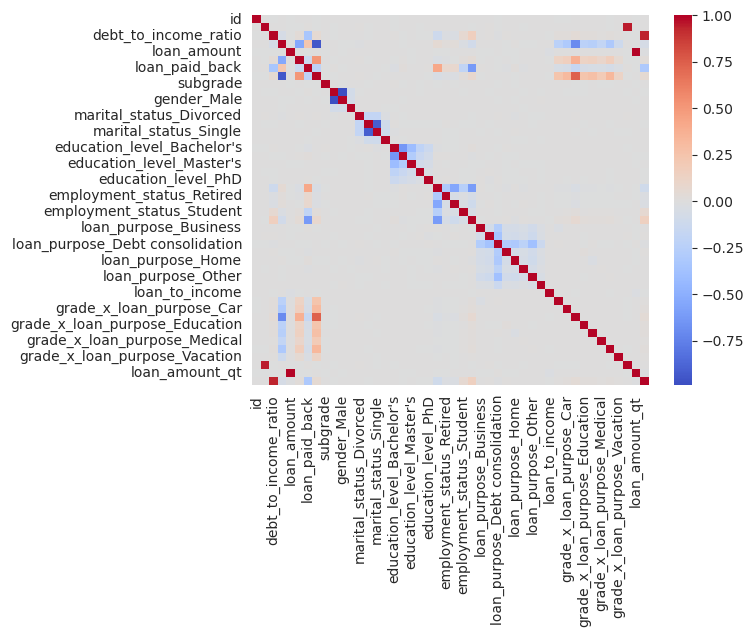

In [11]:
# Correlation Matrix

numeric_df = loan_train_scaled.select_dtypes(include=["int64", "float64"])
sns.heatmap(numeric_df.corr(), cmap="coolwarm", center=0)


## Export Datasets

In [12]:
# Export Feature Engineered Datasets

loan_train_scaled.to_csv("../data/processed/loan_train_features.csv", index=False)
loan_test_scaled.to_csv("../data/processed/loan_test_features.csv", index=False)


# ✅ Summary: Feature Engineering

This notebook completed all key feature-engineering steps required to enhance the predictive power of the cleaned Kaggle loan dataset. The goal of this phase was to enrich the dataset with domain-informed, statistically useful transformations that improve model performance while maintaining train/test consistency.

---

## 🔹 1. Loan-to-Income Ratio (LTI)
A key credit-risk metric was created:

$$
\text{loan\_to\_income} = \frac{\text{loan\_amount}}{\text{annual\_income}}
$$

This ratio captures borrower leverage and is a strong predictor of repayment behavior.

---

## 🔹 2. High DTI (Debt-to-Income) Flag
A binary DTI-risk indicator was generated using a common lending threshold (0.40).
This was followed by **one-hot encoding** to ensure compatibility with ML models:

- `high_dti_flag_0`
- `high_dti_flag_1`

---

## 🔹 3. Credit Score Bucketing
Borrower credit scores were grouped into ordinal categorical buckets:

- `very_low`
- `low`
- `medium`
- `high`
- `very_high`

These were then **one-hot encoded** to preserve category identity without imposing artificial numeric order.

---

## 🔹 4. Interaction Terms
Domain-relevant feature interactions were created to capture nonlinear relationships, including:

- `grade × loan_purpose_*`
- `credit_bucket_code × loan_purpose_*`
- `loan_to_income × interest_rate`
- employment status × interest rate
- `subgrade × loan_amount`

These interaction terms help expose relationships not captured by individual features alone.

---

## 🔹 5. Quantile Transforms (Replaces Log Transforms)
Because prior scaling introduced negative values, log transforms were not appropriate.
Instead, **QuantileTransformers** were applied to smooth skewed numerical features:

- `annual_income_qt`
- `loan_amount_qt`
- `debt_to_income_ratio_qt`

This normalizes distributions, reduces outlier influence, and improves downstream model stability.

---

## 🔹 6. Correlation Validation
A correlation matrix (numeric-only) was generated to validate the impact of engineered features and inspect feature redundancy prior to modeling.

---

## 🔹 7. Final Feature Dataset Export
All engineered features were saved for persistent reuse in future stages:

- `loan_train_features.csv`
- `loan_test_features.csv`

These files serve as the direct inputs for **04_model_training.ipynb**.

---

The dataset is now fully feature-engineered, enriched with domain-driven insights, validated for consistency, and ready for model selection and training.
